# Peer-graded Assignment: The Battle of Neighborhoods

## Objective: define good location for a new business in Frankfurt am Main, Germany

## 1) Description of the problem and a discussion of the background

Frankfurt at Main is known as a very international city in Germany. The developed bank and finance sectors continuously attract skilled workers from abroad. As a consequence, demands on other sectors such as hotels, properties, restaurants, entertainment, and transportation are also increasing and prices are skyrocketing as a consequence. 

To support these changes, the city is opening credit lines for local entrepreneurs to invest in these sectors and enjoy this economical growth.

Observing a good opportunity and knowing that the German cuisine is not quite appealing for foreigners, a skilled Brazilian chef de cuisine decided to apply for the available credit line and also invest all his savings in opening a Philippine restaurant. 

However, the soon to be a restaurant owner is aware of the challenges ahead and given that I) the target clients are very demanding, II) the restaurant location has to be close to the finance and banking area, and III) that the prices of renting in the city are soaring, the business location is crucial for its long-term success.

#### The chef de cuisine hired a data scientist to locate good place for the business. The restaurant has to be within walking distance from the center of the financing neighborhood, close to popular attractions, and avoid being close to other restaurants.

## 2) Description of the data and how it will be used to solve the problem

The target area for the new business location is Frankfurt's banking neighborhood.

The analysis will require Foursquare API to retrieve information about the location, rating, description, and popularity of restaurants and attractions in the area.

The client gave the following rules and recommendations: 

1) The new location has to be at a maximum of 1 km away from the Commerzbank Tower.

2) The new location has to be at a minimum of 200 meters away from any other restaurant and 400 meters away to any other Asian restaurant, such as Japanese, Thai, Vietnamese or Indian.

3) If possible, close to the Main River and/or to attractions.

A real estate agent pre-selected 20 available points for the restaurant and sent the latitude and longitude in a CSV.

#### After obtaining and cleaning the dataset, we are going to apply GIS analysis to determine hotspots for the restaurant implementation.

#### Obtaining data using Foursquare API

In [22]:
import requests
import pandas as pd
import seaborn as sns
import folium
import geopy 
from geopy.distance import distance
from pandas import json_normalize

# frankfurt's finance center lat / lon
fkf_lat=50.110924
fkf_lon=8.682127
fkf_latlon=[fkf_lat,fkf_lon]

# foursquare API credentials are stored in a hidden file
from secret_settings import * 

# foursquare API request parameters
LIMIT = 100 
radius = 3000

# request from Foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(    
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    fkf_latlon[0], 
    fkf_latlon[1], 
    radius, 
    LIMIT)

# get data using requests
raw_data = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter columns
venues = raw_data['response']['groups'][0]['items']  
fkf_location_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
fkf_location_venues =fkf_location_venues.loc[:, filtered_columns]

# filter the category for each row
fkf_location_venues['venue.categories'] = fkf_location_venues.apply(get_category_type, axis=1)

# clean columns
fkf_location_venues.columns = [col.split(".")[-1] for col in fkf_location_venues.columns]

# load available locations for rental that a real estate agent pre-selected
rental_props=pd.read_csv('rent_selected.csv')

#### Data was stored in a Pandas dataframe with name, category, latitude and longitude. Let's check the first 5 rows:

In [23]:
# display first 5 rows
fkf_location_venues

,name,categories,lat,lng
0,Kleinmarkthalle,Market,50.112778,8.682958
1,Góc Phố,Vietnamese Restaurant,50.113509,8.681686
2,Weinterasse Rollanderhof,Wine Bar,50.112473,8.682164
3,Römerberg,Plaza,50.110489,8.682131
4,SCHIRN Kunsthalle,Art Museum,50.110291,8.683542
...,...,...,...,...
95,Parthenon Greek Restaurant,Greek Restaurant,50.101037,8.674486
96,Villa Kennedy,Hotel,50.097360,8.669209
97,Rösterei Hoppenworth & Ploch,Coffee Shop,50.124788,8.691801
98,Oosten,Gastropub,50.107738,8.702760


#### Quick preview on the city bank & finance area map. The presented circle has a 1 km radius from the center of the target neighborhood.

In [3]:
# create research area map 
city_map = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=13)

# add a circle with radius 1 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area - 1 km radius from Commerzbank Tower')).add_to(city_map)

# save the map
city_map.save('city_map.html')

In [4]:
# call the map
city_map

Click [here](city_map.html) if the map doesn't display - GITHUB doesn't render Jupyter Notebook maps properly.

#### Now, using the CSV that the real estate agent sent, we can add markers for the the pre-selected available locations for rental:

In [5]:
# create research area map with rent markers 
city_map_rent = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=14)

# add a circle with radius 1 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area - 1 km radius from Commerzbank Tower')).add_to(city_map_rent)

## create list of markers
map_label = rental_props[['Name']].values.tolist()
map_latlon = rental_props[['lat','lon']].values.tolist()

# add markers 
for point in range(0, len(map_latlon)):
    folium.Marker(map_latlon[point],  popup=map_label[point]).add_to(city_map_rent)


# save the map
city_map_rent.save('city_map_rent.html')

In [6]:
# call the map
city_map_rent

Click [here](city_map_rent.html) if the map doesn't display - GITHUB doesn't render Jupyter Notebook maps properly.

## 4) Data analysis

In this section we are going to make a brief analysis using data obtained through Foursquare API.

In [7]:
# create a series with distinct venues types
venues_type=fkf_location_venues['categories'].value_counts()

# create a dataframe with all restaurants
fkf_restaurants=fkf_location_venues[fkf_location_venues['categories'].str.contains("Restaurant|Trattoria|Bistro")]

# add column to check if restaurant is asian
asian_specific=['Vietnamese','Sushi','Thai','Korean','Chinese','Japanese']
pattern = '|'.join(asian_specific)
check_asian=(fkf_restaurants.categories.str.contains(pattern))
check_asian_df = pd.DataFrame({'asian': check_asian})
fkf_restaurants=fkf_restaurants.join(check_asian_df)

# reorganize data into types to create histograms
fkf_location_venues.loc[fkf_location_venues['categories'].str.contains("Restaurant|Trattoria|Bistro"),'type'] = 'Restaurants'
fkf_location_venues.loc[fkf_location_venues['categories'].str.contains("Wine|Bar|Gastropub|Beer"),'type'] = 'Bars'
fkf_location_venues.loc[fkf_location_venues['categories'].str.contains("Coffee|Café"),'type'] = 'Coffee Shops'
fkf_location_venues.loc[fkf_location_venues['categories'].str.contains("Market|Plaza|Gym|Theater|Museum|Waterfront"),'type'] = 'Attractions'


In [8]:
# histogram with types of venues
venues_hist=fkf_location_venues
venues_hist.dropna(inplace=True)
venues_hist

# histogram with types of restaurants
restaurants_hist=fkf_restaurants[['asian']]*1
restaurants_hist.asian = restaurants_hist.asian.apply(lambda x: 'Asian' if 1 == x else 'Not asian')

#### Histogram with type of venues

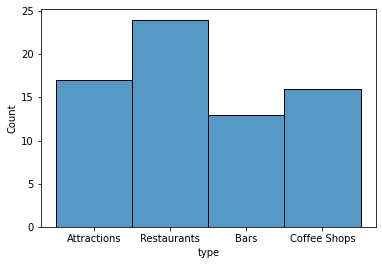

In [9]:
sns.histplot(venues_hist.type)

We can see that most of venues are restaurants, followed by attractions, coffee shops and bars. According to our client, attractions are important and may increase the restaurant popularity. Let's take a look on the attractions:

In [10]:
# retrieve name of all attractions
list_attractions=fkf_location_venues.loc[fkf_location_venues['type'] == 'Attractions']
list_attractions.reset_index(drop=True)

,name,categories,lat,lng,type
0,Kleinmarkthalle,Market,50.112778,8.682958,Attractions
1,Römerberg,Plaza,50.110489,8.682131,Attractions
2,SCHIRN Kunsthalle,Art Museum,50.110291,8.683542,Attractions
3,FITSEVENELEVEN Zeil,Gym / Fitness Center,50.114163,8.682001,Attractions
4,Erzeugermarkt Konstablerwache,Farmers Market,50.114516,8.687116,Attractions
5,Mainufer,Waterfront,50.106268,8.674071,Attractions
6,Schauspiel Frankfurt,Theater,50.108607,8.674736,Attractions
7,Deutsches Filmmuseum,History Museum,50.105313,8.677756,Attractions
8,Opernplatz,Plaza,50.115399,8.671772,Attractions
9,MMK 2,Art Museum,50.110207,8.672162,Attractions


#### Histogram with restaurant categories

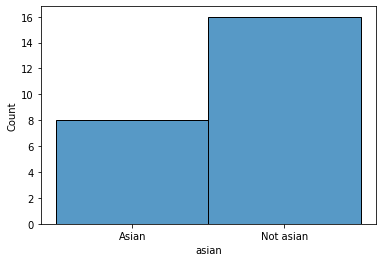

In [11]:
sns.histplot(restaurants_hist.asian)

Fortunately, most restaurants are not asian, which increases our chances to find a good location for our client.

#### Map with all venues in the target area

For our research area, we are going to plot all venues in a map:

In [12]:
# create research area map with markers
city_map_marked = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=15)

# add a circle with radius 2 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area - 1 km radius from Commerzbank Tower')).add_to(city_map_marked)

## create list of markers
map_label = fkf_location_venues[['categories']].values.tolist()
map_latlon = fkf_location_venues[['lat','lng']].values.tolist()

# add markers 
for point in range(0, len(map_latlon)):
    folium.Marker(map_latlon[point],  popup=map_label[point]).add_to(city_map_marked)

# save the map
city_map_marked.save('city_map_marked.html')

In [13]:
# call the map
city_map_marked

Click [here](city_map_marked.html) if the map doesn't display - GITHUB doesn't render Jupyter Notebook maps properly.

However, this map information is not sufficient for our client. Let's remember the rules:

##### 1) The new location has to be at a maximum of 1 km away from the Commerzbank Tower.

#####  2) The new location has to be at a minimum of 200 meters away from any other restaurant and 400 meters away to any other Asian restaurant, such as Japanese, Thai, Vietnamese or Indian.

##### 3) If possible, close to the Main River and/or to attractions.

To help our analysis, we can plot the locations using circular buffer zones around the restaurants, which is described in the following.

#### Map with all venues in the target area with radius (buffer)

Red circles are asian restaurant (400 m radius), blue circles are non-asian restaurants (200 m radius) and green circles are attractions.

In [14]:
# create research area map with markers
city_map_marked_res_buffer = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=15)

# create list of markers
map_label = fkf_restaurants[['name','categories','asian']].values.tolist()
map_latlon = fkf_restaurants[['lat','lng']].values.tolist()

# add a circle with radius 1 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area')).add_to(city_map_marked_res_buffer)

# add buffer areas 
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 m around our center point
    if map_label[point][2]:
        folium.Circle(map_latlon[point],
                        radius=400,
                        fill=True,
                        color='#f78080',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Asian restaurant area')).add_to(city_map_marked_res_buffer)
    else:
        folium.Circle(map_latlon[point],
                        radius=200,
                        fill=True,
                        color='#85ace4',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Non Asian restaurant area')).add_to(city_map_marked_res_buffer)

# create list of buffers for attractions
map_label = fkf_location_venues[['name','type']].values.tolist()
map_latlon = fkf_location_venues[['lat','lng']].values.tolist()
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 m around our center point
    if map_label[point][1] == 'Attractions':
        folium.Circle(map_latlon[point],
            radius=50,
            fill=True,
            color='#35cca8',
            opacity=0.1,
            fill_opacity=0.5
            ).add_child(folium.Popup(map_label[point][0])).add_to(city_map_marked_res_buffer)
    else:
        pass
    
# save the map
city_map_marked_res_buffer.save('city_map_marked_res_buffer.html')


In [15]:
# call the map
city_map_marked_res_buffer

Click [here](city_map_marked_res_buffer.html) if the map doesn't display - GITHUB doesn't render Jupyter Notebook maps properly.

#### Map with all venues in the target area with radius (buffer) and available properties

Now that we have all restaurant areas and attractions on the map, is time for us to load the available rental properties:

In [16]:
# create research area map with markers
analysis_map = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=14)

# create list of markers
map_label = fkf_restaurants[['name','categories','asian']].values.tolist()
map_latlon = fkf_restaurants[['lat','lng']].values.tolist()

# add a circle with radius 1 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area')).add_to(analysis_map)

# add markers 
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 km around our center point
    if map_label[point][2]:
        folium.Circle(map_latlon[point],
                        radius=400,
                        fill=True,
                        color='#f78080',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Asian restaurant area')).add_to(analysis_map)
    else:
        folium.Circle(map_latlon[point],
                        radius=200,
                        fill=True,
                        color='#85ace4',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Non Asian restaurant area')).add_to(analysis_map)

# create list of buffers for attractions
map_label = fkf_location_venues[['name','type']].values.tolist()
map_latlon = fkf_location_venues[['lat','lng']].values.tolist()
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 m around our center point
    if map_label[point][1] == 'Attractions':
        folium.Circle(map_latlon[point],
            radius=50,
            fill=True,
            color='#35cca8',
            opacity=0.1,
            fill_opacity=0.5
            ).add_child(folium.Popup(map_label[point][0])).add_to(analysis_map)
    else:
        pass
        
## create list of markers
map_label = rental_props[['Name']].values.tolist()
map_latlon = rental_props[['lat','lon']].values.tolist()

# add markers 
for point in range(0, len(map_latlon)):
    folium.Marker(map_latlon[point],  popup=map_label[point]).add_to(analysis_map)

# save the map     
analysis_map.save('analysis_map.html')

In [17]:
# call the map
analysis_map

Finally, we can visually inspect the map and determine the best location for the restaurant.

#### Check automatically which available property is suitable for the client

We are going to measure the distances from each property to each restaurant and give a list of best options for renting a place.

In [18]:
temp_list=[]
okpoints_list=[]
pt3 = geopy.Point(fkf_lat,fkf_lon)
list_rental=rental_props.values.tolist()
list_restaurants=fkf_restaurants.values.tolist()
for i in range(0,len(list_rental)):
    for j in range (0,len(list_restaurants)):
        lat_rent=list_rental[i][1]
        lon_rent=list_rental[i][2]
        lat_rest=list_restaurants[j][2]
        lon_rest=list_restaurants[j][3]
        pt1 = geopy.Point(lat_rent,lon_rent)
        pt2 = geopy.Point(lat_rest,lon_rest)
        dist = geopy.distance.distance(pt1, pt2).m
        dist_c = geopy.distance.distance(pt1, pt3).m
        # if restaurant is asian (1) or not (0)
        if list_restaurants[j][4]==1 and dist <400:
            temp_list.append([list_rental[i][0],'Not ok'])
            break
        elif list_restaurants[j][4]==0 and dist <200:     
            temp_list.append([list_rental[i][0],'Not ok'])
            break
        elif dist_c >1000:     
            temp_list.append([list_rental[i][0],'Not ok'])
            break            
        else: 
            pass
        
# get suitable points for rental
for i in range(0,len(list_rental)):
    if any(list_rental[i][0] in s for s in temp_list):
        pass
    else:
        okpoints_list.append([list_rental[i][0],list_rental[i][1],list_rental[i][2],'Suitable location'])

# convert to dataframe
okpoints_df = pd.DataFrame(okpoints_list,columns=['point','lat','lon','situation'])

In [19]:
# create research area map with markers
decision_map = folium.Map(location=[fkf_latlon[0],fkf_latlon[1]], zoom_start=14)

# create list of markers
map_label = fkf_restaurants[['name','categories','asian']].values.tolist()
map_latlon = fkf_restaurants[['lat','lng']].values.tolist()

# add a circle with radius 1 km around our center point
folium.Circle([fkf_latlon[0],fkf_latlon[1]],
                    radius=1000
                   ).add_child(folium.Popup('Research area')).add_to(decision_map)

# add markers 
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 km around our center point
    if map_label[point][2]:
        folium.Circle(map_latlon[point],
                        radius=400,
                        fill=True,
                        color='#f78080',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Asian restaurant area')).add_to(decision_map)
    else:
        folium.Circle(map_latlon[point],
                        radius=200,
                        fill=True,
                        color='#85ace4',
                        opacity=0.1,
                        fill_opacity=0.5
                       ).add_child(folium.Popup('Non Asian restaurant area')).add_to(decision_map)

# create list of buffers for attractions
map_label = fkf_location_venues[['name','type']].values.tolist()
map_latlon = fkf_location_venues[['lat','lng']].values.tolist()
for point in range(0, len(map_latlon)):
    # add a circle with radius 200 or 400 m around our center point
    if map_label[point][1] == 'Attractions':
        folium.Circle(map_latlon[point],
            radius=50,
            fill=True,
            color='#35cca8',
            opacity=0.1,
            fill_opacity=0.5
            ).add_child(folium.Popup(map_label[point][0])).add_to(decision_map)
    else:
        pass
        
## create list of markers
map_label = okpoints_df[['point']].values.tolist()
map_latlon = okpoints_df[['lat','lon']].values.tolist()

# add markers 
for point in range(0, len(map_latlon)):
    folium.Marker(map_latlon[point],  popup=map_label[point]).add_to(decision_map)

# save the map     
decision_map.save('decision_map.html')

In [20]:
# call the decision map
decision_map

#### Finally, from all possible renting places, these points represent the best options according to the client's constraints. Instead of visiting 20, the client will visit only four.


In [27]:
okpoints_df

,point,lat,lon,situation
0,P5,50.106908,8.690968,Suitable location
1,P11,50.104008,8.681878,Suitable location
2,P16,50.115471,8.671816,Suitable location
3,P20,50.113887,8.694161,Suitable location
